# Introduction

The [Humanitarian Data Exhcange](https://data.humdata.org/) (HDX) is a fantastic platform for storing humanitarian datasets, key to timely and efficient response to humanitarian disasters. The data on the this platform is sourced from all around the world. One key aspect to this platform is the use of [Humanitarian Exchange Language](https://hxlstandard.org/?_gl=1*p7ffaf*_ga*OTc2MzE0MTI5LjE2NzAxMDE2NjE.*_ga_E60ZNX2F68*MTY3MzQ5NDk2NS4xOC4xLjE2NzM0OTUzNjQuNjAuMC4w) (HXL) tags. This meta data provides important meta data enables faster automatic integration and interoperability, as well as a way to link datasets together. 

Tags come in two forms, those set at the dataset level, and field-level tags which apply to columns in tabular data, which look like:



| FDF       | PAHO Sub-Region     | ISO-3              | Country / territory | IFRC Sub-Region | Population        | Tracker Update Date  | Data Publication Date  | EPI Week (year)    | EPI Week (outbreak)    | Cases     |
|-----------|---------------------|--------------------|---------------------|-----------------|-------------------|----------------------|------------------------|--------------------|------------------------|-----------|
| #severity | #region             | #country+code+iso3 | #country+name       | #region+ifrc    | #population+total | #date+tracker+update | #date+data+publication | #date+epiweek+year | #date+epiweek+outbreak | #affected |
| Confirmed | Non Latin Caribbean | BRB                | Barbados            | Americas        | 283380            | 15th February 2016   | 2016-02-12             | 6                  | 21                     | 7         |
| Deaths    | Non Latin Caribbean | BRB                | Barbados            | Americas        | 283380            | 15th February 2016   | 2016-02-12             | 6                  | 21                     | 0         |
| Suspected | Non Latin Caribbean | BRB                | Barbados            | Americas        | 283380            | 15th February 2016   | 2016-02-12             | 6                  | 21                     | 0         |

[ *You can see more examples [here](https://hxlstandard.org/hxlexample/)* ]

Notice the second row just below the column headers, those are the tags. They consist of the 'Tag' which is prefixed with a `#` and in some cases following attributes, eg `#country+code+iso3`

The issue is that these field-level tags are not set on all datasets in HDX, making it harder to use data. There has been some work previously on predicting HDX field tags, see [this notebook](https://github.com/humanitarian-data-collaboration/hdx-python-model) and [this paper](https://www.kdd.org/kdd2019/docs/Humanitarian_Data_tagging_KDD2019_SocialImpactTrack_HXLTagPrediction.pdf), but this work predicts just the tag and not the attributes after the tag. 

This notebook demonstrates how we can use [GPT-3](https://openai.com/blog/gpt-3-apps/) to predict not only HXL field tags, but also tag attributes. 

Matthew Harris

# Setup

1. See Conda environment ../environment.yml if you want to run this notebook locally
2. For running OpenAI you will need to create a file called `api_key.txt` in the current directory and put your [OpenAI API key](https://beta.openai.com/account/api-keys) in there (just the API string, nothing else)
3. Edit the variable 'country' below to set which country you wish to prredict tags for

No setup is needed for HDX integration as we're using open datasets and reading, so they are open in the API.

In [23]:
# Installation of the api
#%pip install hdx-python-api==5.9.3
#%pip install sklearn==1.2.0
#%pip install openai==0.26.0#
#%pip install bs4==0.0.1
#%pip install lxml==4.9.2
#%pip install html5lib

Note: you may need to restart the kernel to use updated packages.


In [142]:
from hdx.utilities.easy_logging import setup_logging
from hdx.api.configuration import Configuration
from hdx.data.dataset import Dataset

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import json
import os
import chardet
import shutil
import sys
import re
import traceback
import zipfile
import time

import numpy as np
from sklearn.model_selection import train_test_split
import openai
from openai import cli

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

from random import sample

# Open AI API key should be put into this file
openai.api_key_path = "./api_key.txt"

pd.set_option("display.max_rows", 500)

country = "Kenya"


# Get HDX Data

In [2]:
# Logging in and getting read only access to https://data.humdata.org
# Read more about API Access token in documentation at https://hdx-python-api.readthedocs.io/en/latest/
# for writing access.

agent_count = 0

def setup_hdx_connection(agent_name):
    setup_logging()
    Configuration.create(hdx_site="prod", user_agent=agent_name, hdx_read_only=True)


setup_hdx_connection(f"DK_UserAgent{agent_count}")

2023-01-12 17:42:21.522 | INFO     | hdx.api.configuration:__init__:95 - No HDX base configuration parameter. Using default base configuration file: /Users/matthewharris/opt/miniconda3/envs/dk_analysis/lib/python3.8/site-packages/hdx/api/hdx_base_configuration.yml.
2023-01-12 17:42:21.523 | INFO     | hdx.api.configuration:__init__:98 - Loading HDX base configuration from: /Users/matthewharris/opt/miniconda3/envs/dk_analysis/lib/python3.8/site-packages/hdx/api/hdx_base_configuration.yml
2023-01-12 17:42:21.536 | INFO     | hdx.api.configuration:__init__:133 - No HDX configuration parameter and no configuration file at default path: /Users/matthewharris/.hdx_configuration.yml.
2023-01-12 17:42:21.537 | INFO     | hdx.api.configuration:__init__:222 - Read only access to HDX: True


## Build a master list of datasets, resources, tags and groups for all countries

In [ ]:
def extract_json_from_hdx_meta(hdx_object):
    """
    This function takes a HDX Python object as input and returns a JSON object.

    Parameters
    ----------
    hdx_object : HDX object
        The HDX object to be converted to JSON.

    Returns
    -------
    json_op : JSON object
        The JSON object created from the HDX object.
    """
    json_op = {}
    for key in hdx_object:
        json_op[key] = hdx_object[key]
    json_op = json.dumps(json_op, indent=4)
    return json.loads(json_op)


print(f"Searching for ALL datasets in HDX")
datasets = Dataset.search_in_hdx()

print(f"Extracting resource list for each dataset")
resources_output = []
tags_output = []
groups_output = []

for d in datasets:
    try:
        dataset = Dataset.read_from_hdx(d["id"])
    except:
        print(f"Error reading dataset: {d['id']}")
        time.sleep(30)
        dataset = Dataset.read_from_hdx(d["id"])

    for tag in dataset["tags"]:
        t = {
            "tag_name": tag["name"],
            "tag_display_name": tag["display_name"],
            "tag_vocabulary_id": tag["vocabulary_id"],
        }
        t.update(dataset)
        t = pd.json_normalize(t, max_level=1)
        tags_output.append(t)

    for group in dataset["groups"]:
        g = {
            "group_name": group["name"],
            "group_display_name": group["display_name"],
            "group_title": group["title"],
            "group_display_name": group["display_name"],
        }
        g.update(dataset)
        g = pd.json_normalize(g, max_level=1)
        groups_output.append(g)

    print(f"Extracting resources for dataset: {dataset['title']}")
    resources = dataset.get_resources()
    for resource in resources:
        resource = extract_json_from_hdx_meta(resource)
        resource.update(extract_json_from_hdx_meta(dataset))
        resource = pd.json_normalize(resource, max_level=1)
        resources_output.append(resource)

print("Building output dataframe")
resources_output = pd.concat(resources_output)
datasets_output = pd.DataFrame(datasets)
tags_output = pd.concat(tags_output)
groups_output = pd.concat(groups_output)

# You might get some errors due to very long URLS, affecting a few rows
print("Writing output to excel")
with pd.ExcelWriter(f"./data/{country}_datasets_resources_tags_groups.xlsx") as writer:
    datasets_output.to_excel(writer, sheet_name=f"Datasets")
    resources_output.to_excel(writer, sheet_name=f"Dataset Resources")
    tags_output.to_excel(writer, sheet_name=f"Dataset Tags")
    groups_output.to_excel(writer, sheet_name=f"Dataset Groups")

print("Done")

In [9]:
# Save to pkl files so we can easily start
resources_output.to_pickle("./data/resources.pkl")
datasets_output.to_pickle("./data/datasets.pkl")
tags_output.to_pickle("./data/tags.pkl")
groups_output.to_pickle("./data/groups.pkl")
print("Done")

Done


We have 22089 datasets in HDX
We have 148734 resources in HDX
Index(['format', 'counts'], dtype='object') counts


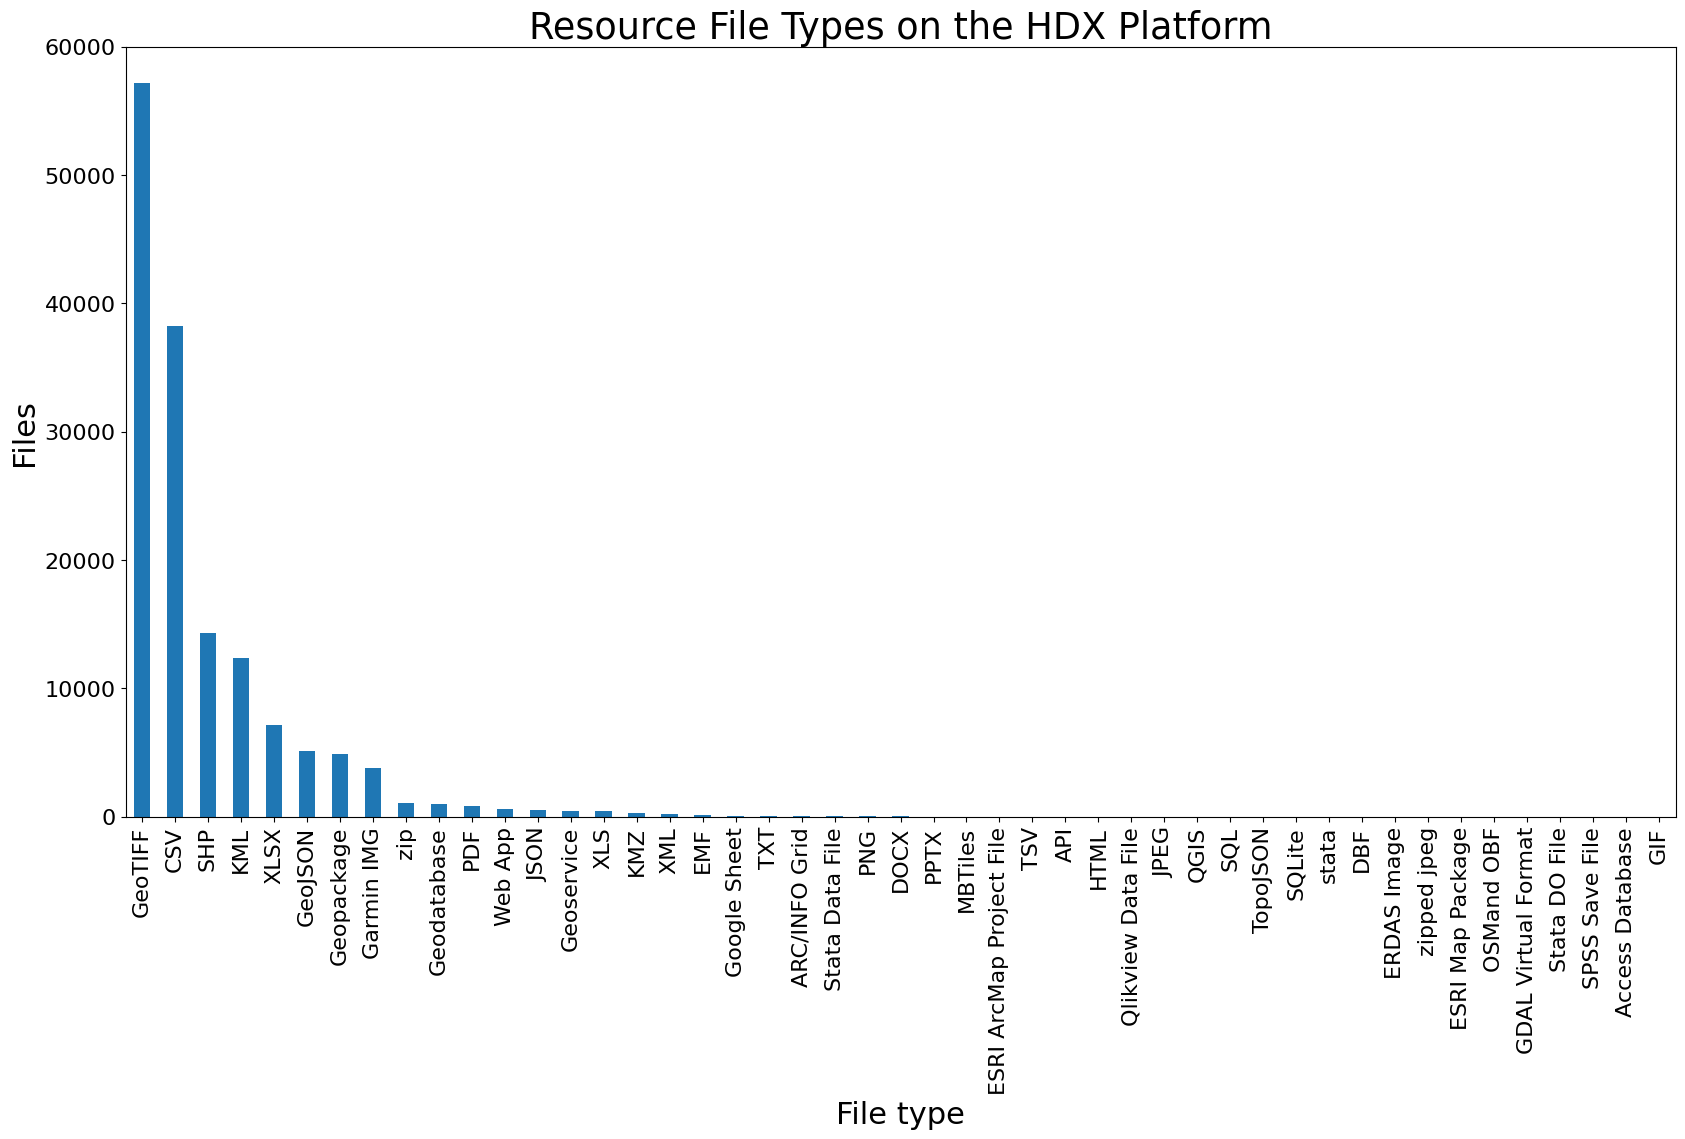


Top 100 tags ...


,tag_name,counts
167,geodata,9132
205,hxl,8416
210,indicators,6335
179,health,2432
376,transportation,2205
139,facilities and infrastructure,1976
117,education,1959
38,baseline population,1834
116,economics,1700
156,food security,1588



Top 100 groups ...


,group_display_name,counts
238,United States,654
248,World,515
119,Kenya,454
50,Colombia,414
74,Ethiopia,375
62,Democratic Republic of the Congo,371
210,South Sudan,365
207,Somalia,362
233,Uganda,347
0,Afghanistan,337


In [97]:
#resources_output = pd.read_pickle('./data/resources.pkl')
#datasets_output = pd.read_pickle('./data/datasets.pkl')
#tags_output = pd.read_pickle('./data/tags.pkl')
#groups_output = pd.read_pickle('./data/groups.pkl')


def plot_sorted_bar_chart(
    df, x, y, title, xlabel, ylabel, figsize=(10, 10), rotation=0
):
    """
    Utility function for simple bar plots

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe to be plotted.
    x : str
        The column name of the x-axis.
    y : str
        The column name of the y-axis.
    title : str
        The title of the plot.
    xlabel : str
        The label of the x-axis.
    ylabel : str
        The label of the y-axis.
    figsize : tuple
        The size of the figure.
    rotation : int
        The rotation of the x-axis labels.

    """
    totals = df.groupby([x]).size().reset_index(name=y)
    print(totals.columns, y)
    totals = totals.sort_values(by=y, ascending=False)
    totals.plot.bar(x=x, y=y, figsize=figsize, rot=rotation, fontsize=16, legend=False)
    plt.rcParams.update({'font.size': 22}) 
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


def display_totals(df, x, y, n):
    """
    This function takes a dataframe, a column name, a column name, and an integer.
    It returns a dataframe with the top n rows of the dataframe sorted by the column name.

    Parameters
    ----------
    df : dataframe
        The dataframe to be sorted.
    x : string
        The column name to be used to group data
    y : string
        Name of the count column

    """
    totals = df.groupby([x]).size().reset_index(name=y)
    totals = totals.sort_values(by=y, ascending=False)
    display(totals[0:n])


print("We have {} datasets in HDX".format(len(datasets_output)))
print("We have {} resources in HDX".format(len(resources_output)))

plot_sorted_bar_chart(
    resources_output,
    "format",
    "counts",
    "Resource File Types on the HDX Platform",
    "File type",
    "Files",
    rotation=90,
    figsize=(20, 10),
)

print("\nTop 100 tags ...")
display_totals(tags_output, "tag_name", "counts", 100)

print("\nTop 100 groups ...")
display_totals(groups_output, "group_display_name", "counts", 100)

### Download data files from HDX

So we can interrogate files to get column names, field level HDX tags and data sample, we need to download them. This download is imperfect at this time, known issues are:

1. Zip files - we leave unpacked for now will come back to this
2. Timeouts - large files seem to timeout, couldn't see a way to adjust this in python module

Due to the above the following following panel will need to be run a few times. Since the aim of this analysis is to get a reasonable set of tabular data for explorations, this should suffice for now. But some work in the future to harden this process. I suspect the best way forward for full control would be to hit the [REST API](https://docs.ckan.org/en/2.9/api/) directly.

In [35]:
def check_hdx_header(first_row):
    """
    This function checks if the first row of a csv file likely an HDX header.
    """
    matches = ["#meta", "#country", "#data", "#loc", "#geo"]
    if any(x in first_row for x in matches):
        return True
    else:
        return False


def set_meta_data_fields(data, file, dataset, resource, sheet, type):

    """
    This function create a data frame with meta data about the data, as well as a snippet of its
    first nrows.

    Parameters:
        data: a dataframe
        file: the name of the data file
        dataset: the dataset JSON object from HDX
        resource: the resource JSON object from HDX
        sheet: the sheet name if the data was a tab in a sheet
        type: the type of file, CSV, XLSX, etc.
    Returns:
        dict: a dictionary with metadata about the dataframe
    """

    nrows = 10

    # Data preview to only include values
    data = data.dropna(axis=1, how="all")

    cols = str(list(data.columns))
    if data.shape[0] > 0:
        first_row = str(list(data.iloc[0]))
        has_hxl_header = check_hdx_header(first_row)
        num_rows = int(data.shape[0])
        num_cols = int(data.shape[1])
        first_nrows = data.head(nrows)
    else:
        first_row = "No data"
        has_hxl_header = "No data"
        num_rows = 0
        num_cols = 0
        first_nrows = None

    dict = {}

    dict["resource_id"] = resource["id"]
    dict["resource_name"] = resource["name"]
    dict["resource_format"] = resource["format"]
    dict["dataset_id"] = dataset["id"]
    dict["dataset_name"] = dataset["name"]
    dict["dataset_org_title"] = dataset["organization"]["title"]
    dict["dataset_last_modified"] = dataset["last_modified"]
    dict["dataset_tags"] = dataset["tags"]
    dict["dataset_groups"] = dataset["groups"]
    dict["dataset_total_res_downloads"] = dataset["total_res_downloads"]
    dict["dataset_pageviews_last_14_days"] = dataset["pageviews_last_14_days"]
    dict["file"] = file
    dict["type"] = type
    dict["dataset"] = dataset
    dict["sheet"] = sheet
    dict["resource"] = resource
    dict["num_rows"] = num_rows
    dict["num_cols"] = num_cols
    dict["columns"] = cols
    dict["first_row"] = first_row
    dict["has_hxl_header"] = has_hxl_header
    dict["first_nrows"] = first_nrows
    return dict


def extract_data_details(f, dataset, resource, nrows, data_details):
    """

    Reads saved CVS and XLSX HDX files and extracts headers, HDX tags and sample data.
    For XLSX files, it extracts data from all sheets.

    Parameters
    ----------
    f : str
        The file name
    dataset : str
        The dataset name
    resource : str
        The resource name
    nrows : int
        The number of rows to read
    data_details : list
        The list of data details

    Returns
    -------
    data_details : list
        The list of data details

    """
    if f.endswith(".xlsx") or f.endswith(".xls"):
        print(f"Loading xslx file {f} ...")
        try:
            sheet_to_df_map = pd.read_excel(f, sheet_name=None)
        except Exception:
            print("An exception occurred trying to read the file {f}")
            return data_details
        for sheet in sheet_to_df_map:
            data = sheet_to_df_map[sheet]
            data_details.append(
                set_meta_data_fields(data, f, dataset, resource, sheet, "xlsx")
            )
    elif f.endswith(".csv"):
        print(f"Loading csv file {f}")
        # Detect encoding
        with open(f, "rb") as rawdata:
            r = chardet.detect(rawdata.read(100000))
        try:
            data = pd.read_csv(f, encoding=r["encoding"], encoding_errors="ignore")
        except Exception:
            print("An exception occurred trying to read the file {f}")
            return data_details
        data_details.append(set_meta_data_fields(data, f, dataset, resource, "", "csv"))
    else:
        type = f.split(".")[-1]
        print(f"Type {type} for {f}")
        data = pd.DataFrame()
        data_details.append(set_meta_data_fields(data, f, dataset, resource, "", type))

    return data_details


# Loop through downloaded folders
def extract_all_data_details(startpath, data_details):
    """
    Extracts all data details from all datasets in the given directory.

    Parameters
    ----------
    startpath : str
        The path to the directory containing all datasets.
    data_details : list
        Results

    Returns
    -------
    data_details : pandas.DataFrame
        Results, to which new meta data was appended
    """
    for d in os.listdir(startpath):
        if ".DS_" not in d:
            d = f"{startpath}/{d}"
            with open(f"{d}/dataset.json") as f:
                dataset = json.load(f)
            for r in os.listdir(d):
                if "dataset.json" not in r and ".DS_" not in r:
                    with open(f"{d}/{r}/resource.json") as f:
                        resource = json.load(f)
                    for f in os.listdir(f"{d}/{r}"):
                        file = str(f"{d}/{r}/{f}")
                        if ".json" not in file and ".DS_" not in file:
                            data_details = extract_data_details(
                                file, dataset, resource, 5, data_details
                            )
    data_details = pd.DataFrame(data_details)
    return data_details


def is_supported_filetype(format):
    """
    Checks if the file format is currently supported for extracting meta data.

    Parameters
    ----------
    format : str
        The file format to check.

    Returns
    -------
    bool
        True if the file format is supported, False otherwise.
    """
    matches = ["CSV", "XLSX", "XLS", "ZIP", "TSV"]
    if any(x in format for x in matches):
        return True
    else:
        return False


def download_data(datasets, output_folder):
    """
    Downloads data from HDX. Will save dataset and resource meta data for each file

    Parameters
    ----------
    datasets : pandas.DataFrame
        A dataframe containing the datasets to download.
    output_folder : str
        The folder to download the data to.

    """
    if not os.path.exists(output_folder):
        os.mkdir(output_folder)

    for index, row in datasets.iterrows():
        dataset = Dataset.read_from_hdx(row["id"])
        resources = dataset.get_resources()
        for resource in resources:
            dir = f"./{output_folder}/{row['name']}_{row['id']}"
            print(
                f"Downloading {row['name']} - {resource['name']} - {resource['format']}"
            )
            resource["dataset_name"] = row["name"]
            if not os.path.exists(dir):
                dump_hdx_meta_file(dataset, dir, "dataset.json")
            # We need a try/catch because sometimes the HDX API times out
            try:
                dir = f'{dir}/{get_safe_name(resource["name"])}_{get_safe_name(resource["id"])}'
                if not os.path.exists(dir):
                    dump_hdx_meta_file(resource, dir, "resource.json")
                    if is_supported_filetype(resource["format"]):
                        url, path = resource.download(dir)
                        # Unzip zipped files. TODO actually likely won't work as HDX zip files don't end with
                        # .zip, but rather have zip in name, for example file.zip.shp will actually be a zip file
                        # with multiple files. Will come back to thia.
                        if path.endswith(".zip"):
                            print(f"Unzipping {path}")
                            with zipfile.ZipFile(path, "r") as zip_ref:
                                zip_ref.extractall(dir)
                    else:
                        # TODO Add support for skipped file types
                        print(
                            f"*** Skipping file as it is not a supported filetype *** {resource['name']}"
                        )
                else:
                    print(f"Skipping {dir} as it already exists")
            except Exception as e:
                traceback.print_exc()
                print(
                    f"An exception occurred trying to analyze the dataset {row['name']}"
                )
                sys.exit()

    print("Done")


def extract_json_from_hdx_meta(hdx_object):
    """
    This function takes a HDX object as input and returns a JSON object.

    Parameters:
    hdx_object (dict): A HDX object

    Returns:
    json_op (str): A JSON object
    """
    json_op = {}
    for key in hdx_object:
        json_op[key] = hdx_object[key]
    json_op = json.dumps(json_op, indent=4)
    return json_op


def dump_hdx_meta_file(hdx_object, dir, filename):
    """
    This function takes in a HDX object and dumps the metadata in a json file.

    Parameters:

    hdx_object (object): HDX object
    dir (str): Directory where the json file is to be dumped
    filename (str): Name of the json file

    Returns:
    None
    """
    if not os.path.exists(dir):
        os.mkdir(dir)
    json_op = extract_json_from_hdx_meta(hdx_object)
    with open(f"{dir}/{filename}", "w") as f:
        f.write(json_op)


def get_safe_name(name):
    """
    This function takes a string and returns a version of it that is safe to use as a filename.

    Parameters:
        name (str): The string to be converted to a safe filename.

    Returns:
        str: The safe filename.
    """
    return re.sub("[^0-9a-zA-Z]+", "_", name)


def list_files(startpath):
    """
    lists all the files in a path, with some indenting.

    Parameters
    ----------
    startpath : str
        The path to the directory to be listed.

    """
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, "").count(os.sep)
        indent = " " * 4 * (level)
        print("{}{}/".format(indent, os.path.basename(root)))
        subindent = " " * 4 * (level + 1)
        for f in files:
            print("{}{}".format(subindent, f))

##  Download Kenya Data

In [ ]:
datasets = pd.read_pickle("./data/datasets.pkl")

# Subset to {country} as set above
datasets_subset = datasets.loc[datasets["groups"].astype(str).str.contains(country)]

print(f"Found {len(datasets_subset)} datasets for {country} in HDX")
download_data(datasets_subset, f"./data/{country}", agent_count)

### Build Metadata summary for Kenya with details extracted from data files

We will scan through the downloaded files and extract data and meta data. This extract will process csv data files, plus all sheets in Excel files. 

In [ ]:
resources_data_details = extract_all_data_details(f"./data/{country}", [])
resources_data_details.to_pickle(f"./data/{country}_data_details.pkl")
print("Done")

### Check how many of our Kenyan files have HXL tags

Index(['has_hxl_header', 'counts'], dtype='object') counts


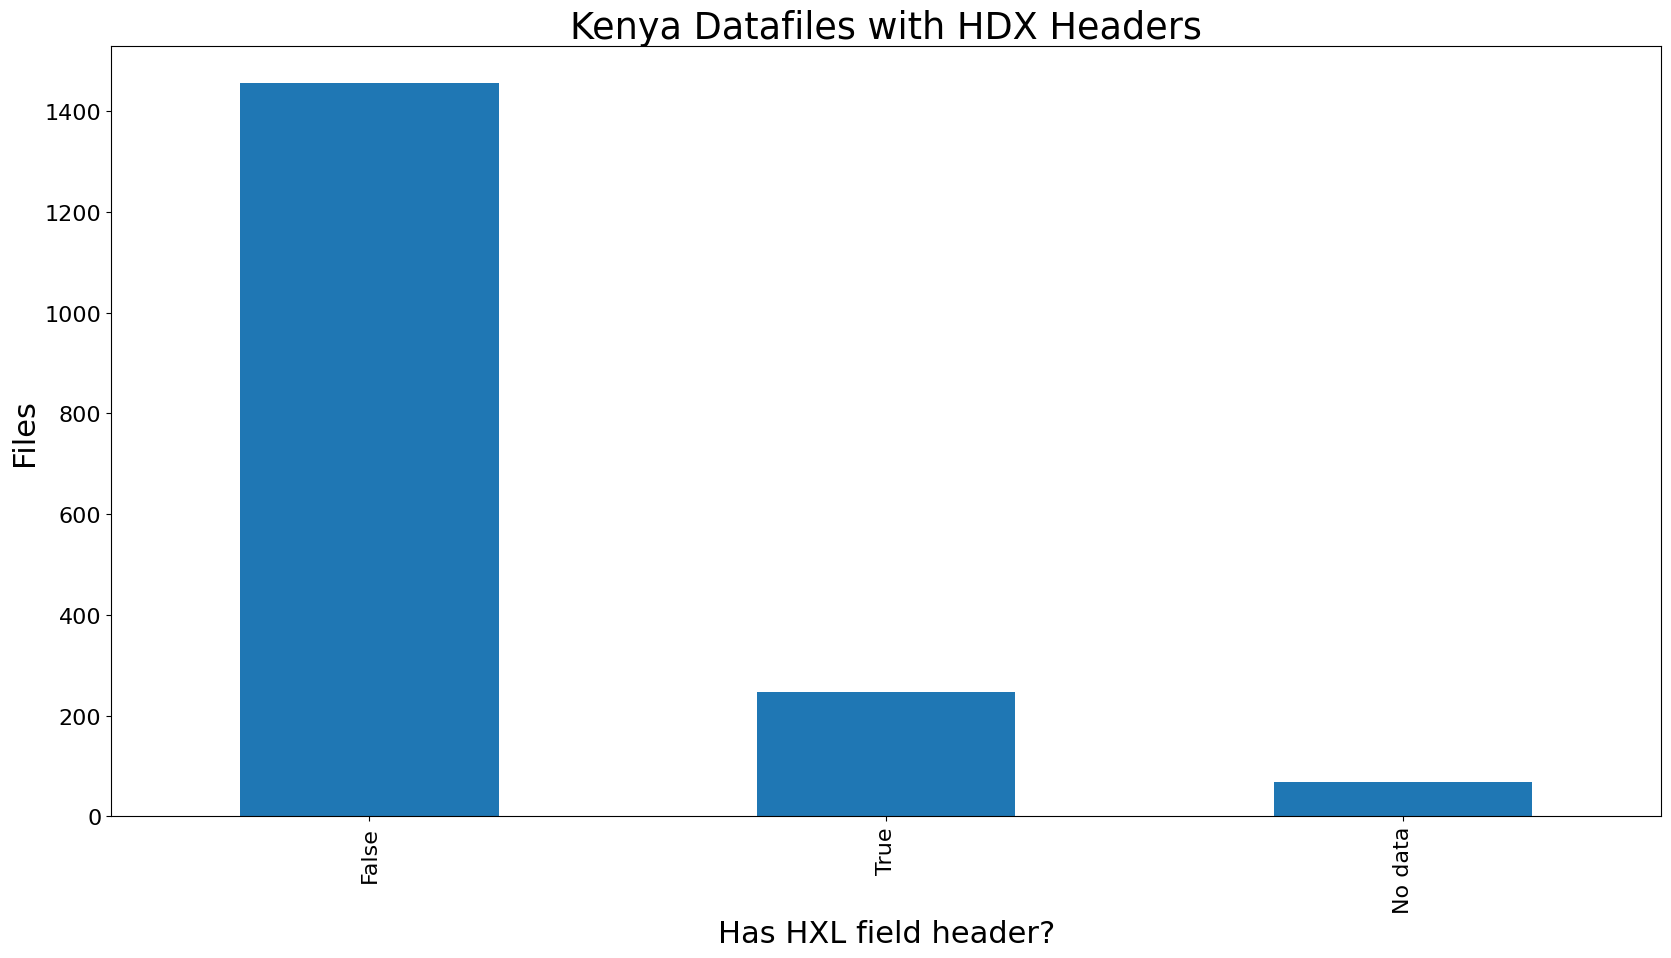

In [98]:
resources_data_details = pd.read_pickle(f"./data/{country}_data_details.pkl")
plot_sorted_bar_chart(
    resources_data_details,
    "has_hxl_header",
    "counts",
    f"{country} Datafiles with HDX Headers",
    "Has HXL field header?",
    "Files",
    rotation=90,
    figsize=(20, 10),
)

So we can see a lot of HXL tags seem to be missing for this country.

## Predicting HXL field tags

OK, so we need to predict some tags. 

### Downloading data with HXL tags

First we will download data likely to have HXL tags by searching for 'HXL'

In [ ]:
datasets_hxl = pd.DataFrame(Dataset.search_in_hdx("HXL"))
print(datasets_hxl.shape)
display(datasets_hxl.head())

In [ ]:
datasets_hxl.to_excel(f"./data/datasets_hxl.xlsx")

Now, we download ...

In [ ]:
output_folder = f"./data/hxl_datasets"
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

download_data(datasets_hxl, output_folder, agent_count, errors="ignore")

### Extract Meta data for downloaded data that has HXL tags

In [ ]:
hxl_resources_data_details = extract_all_data_details(f"./data/hxl_datasets/", [])
hxl_resources_data_details.to_pickle(f"./data/hxl_data_details.pkl")
print("Done")

In [202]:
hxl_resources_data_details = pd.read_pickle(f"./data/hxl_data_details.pkl")
display(hxl_resources_data_details.head())

,resource_id,resource_name,resource_format,dataset_id,dataset_name,dataset_org_title,dataset_last_modified,dataset_tags,dataset_groups,dataset_total_res_downloads,...,type,dataset,sheet,resource,num_rows,num_cols,columns,first_row,has_hxl_header,first_nrows
0,bd15032b-57b2-47ca-87e0-09a6c1a58d1f,Literacy Data for Rwanda,CSV,fa20a295-e75b-4ac2-b00e-65bb43626faa,dhs-data-for-rwanda,The DHS Program,2020-03-20T23:05:25.396054,"[{'display_name': 'demographics', 'id': '7aa60...","[{'description': '', 'display_name': 'Rwanda',...",5480,...,csv,"{'archived': False, 'batch': '6e71bebe-0a04-4c...",,{'alt_url': 'https://data.humdata.org/dataset/...,108,25,"['ISO3', 'DataId', 'Indicator', 'Value', 'Prec...","['#country+code', '#meta+id', '#indicator+name...",True,ISO3 DataId ...
1,a4ce98da-69b5-499b-8f9d-fd1b7e6685f0,Anemia Data for Rwanda,CSV,fa20a295-e75b-4ac2-b00e-65bb43626faa,dhs-data-for-rwanda,The DHS Program,2020-03-20T23:05:25.396054,"[{'display_name': 'demographics', 'id': '7aa60...","[{'description': '', 'display_name': 'Rwanda',...",5480,...,csv,"{'archived': False, 'batch': '6e71bebe-0a04-4c...",,{'alt_url': 'https://data.humdata.org/dataset/...,61,25,"['ISO3', 'DataId', 'Indicator', 'Value', 'Prec...","['#country+code', '#meta+id', '#indicator+name...",True,ISO3 DataId ...
2,74d7b898-dacb-4538-a7e5-51797f209e10,HIV Prevalence Data for Rwanda,CSV,fa20a295-e75b-4ac2-b00e-65bb43626faa,dhs-data-for-rwanda,The DHS Program,2020-03-20T23:05:25.396054,"[{'display_name': 'demographics', 'id': '7aa60...","[{'description': '', 'display_name': 'Rwanda',...",5480,...,csv,"{'archived': False, 'batch': '6e71bebe-0a04-4c...",,{'alt_url': 'https://data.humdata.org/dataset/...,94,27,"['ISO3', 'DataId', 'Indicator', 'Value', 'Prec...","['#country+code', '#meta+id', '#indicator+name...",True,ISO3 DataId ...
3,9e384243-f0c3-461d-9eff-2e2cb335252d,MDGs Data for Rwanda,CSV,fa20a295-e75b-4ac2-b00e-65bb43626faa,dhs-data-for-rwanda,The DHS Program,2020-03-20T23:05:25.396054,"[{'display_name': 'demographics', 'id': '7aa60...","[{'description': '', 'display_name': 'Rwanda',...",5480,...,csv,"{'archived': False, 'batch': '6e71bebe-0a04-4c...",,{'alt_url': 'https://data.humdata.org/dataset/...,179,27,"['ISO3', 'DataId', 'Indicator', 'Value', 'Prec...","['#country+code', '#meta+id', '#indicator+name...",True,ISO3 DataId ...
4,90992dc5-37d8-453e-ad34-6963eb475efa,SDGs Data for Rwanda,CSV,fa20a295-e75b-4ac2-b00e-65bb43626faa,dhs-data-for-rwanda,The DHS Program,2020-03-20T23:05:25.396054,"[{'display_name': 'demographics', 'id': '7aa60...","[{'description': '', 'display_name': 'Rwanda',...",5480,...,csv,"{'archived': False, 'batch': '6e71bebe-0a04-4c...",,{'alt_url': 'https://data.humdata.org/dataset/...,118,27,"['ISO3', 'DataId', 'Indicator', 'Value', 'Prec...","['#country+code', '#meta+id', '#indicator+name...",True,ISO3 DataId ...


In [108]:
print(hxl_resources_data_details.shape)

(25695, 22)


### Create some training data

We need to create training data where every row relates to a column in a datafile, for which we need HXL tags. 

When I first tried this, I downloaded data, created by the data then did a typical test/train split. However, I noticed that columns from resources (files) in the same dataset could occur in both training and test. I felt this an unrealistic test, because when we predict in the wild it will be for a dataset that likely wasn't in the traning data. So being cautious I made the test/train split by ...

1. Create a unique list of datasets (Note: In HDX a dataset can hold multiple 'resources', ie data files)
2. Used the classic scikit learn train_test_split to split dataset dataframe
3. Then using the train and test datasets, I built corresponding train/test resources (files) datafraes
4. Using thes resources train/test dataframes, I finally built the model train/test dataframes wiith a row per column

Convoluted, I know, but I felt it was more realistic.

#### Split HXL datasets into train/test, then use to to create train/test dataframes of resources (files) 

In [203]:
hdx_datasets = []
for row, data in hxl_resources_data_details.iterrows():
    d = {"name": data["dataset"]["title"], "id": data["dataset"]["id"]}
    hdx_datasets.append(d)

hdx_datasets = pd.DataFrame(hdx_datasets)
hdx_datasets = hdx_datasets.drop_duplicates(subset=["id"])

# Train test split on datasets to avoid having very similar columns in train and test
X_train_datasets, X_test_datasets = train_test_split(
    hdx_datasets, test_size=0.3, random_state=42
)

print(f"Train datasets: {len(X_train_datasets)}")
print(f"Test datasets: {len(X_test_datasets)}")

X_train_resources = []
X_test_resources = []
for row, data in hxl_resources_data_details.iterrows():
    if data["dataset"]["id"] in X_train_datasets["id"].values:
        X_train_resources.append(data)
    else:
        X_test_resources.append(data)

X_train_resources = pd.DataFrame(X_train_resources)
X_test_resources = pd.DataFrame(X_test_resources)

# Now lets prune resources which don't have HDX headers. Even though our search was for 'HXL', not all resources have HXL headers
X_train_resources = X_train_resources.loc[X_train_resources["has_hxl_header"] == True]
X_test_resources = X_test_resources.loc[X_test_resources["has_hxl_header"] == True]

# To be similiar with previous prediction studies, we'll only use CSV which are generally cleaner on HDX because they
# don't have a lot of random tabs  
X_train_resources = X_train_resources.loc[X_train_resources["resource_format"] == "CSV"]
X_test_resources = X_test_resources.loc[X_test_resources["resource_format"] == "CSV"]

print(f"Train resources: {len(X_train_resources)}")
print(f"Test resources: {len(X_test_resources)}")

display(X_train_resources.head())

Train datasets: 2530
Test datasets: 1085
Train resources: 12970
Test resources: 5713


,resource_id,resource_name,resource_format,dataset_id,dataset_name,dataset_org_title,dataset_last_modified,dataset_tags,dataset_groups,dataset_total_res_downloads,...,type,dataset,sheet,resource,num_rows,num_cols,columns,first_row,has_hxl_header,first_nrows
67,c144ee8a-cbe6-4159-836a-79a87c4bcf63,Social Development Indicators for Bhutan,CSV,d0d61099-c466-499a-8989-1f898d095b03,world-bank-social-development-indicators-for-b...,World Bank Group,2022-12-27T13:50:41.047263,"[{'display_name': 'development', 'id': '3be50d...","[{'description': '', 'display_name': 'Bhutan',...",401,...,csv,"{'archived': False, 'batch': '0cb56400-6f98-4b...",,{'alt_url': 'https://data.humdata.org/dataset/...,793,6,"['Country Name', 'Country ISO3', 'Year', 'Indi...","['#country+name', '#country+code', '#date+year...",True,Country Name Country ISO3 Year \...
68,d1e64e90-b78d-4d6c-9d7f-d9ca9351b280,QuickCharts-Social Development Indicators for ...,CSV,d0d61099-c466-499a-8989-1f898d095b03,world-bank-social-development-indicators-for-b...,World Bank Group,2022-12-27T13:50:41.047263,"[{'display_name': 'development', 'id': '3be50d...","[{'description': '', 'display_name': 'Bhutan',...",401,...,csv,"{'archived': False, 'batch': '0cb56400-6f98-4b...",,{'alt_url': 'https://data.humdata.org/dataset/...,117,4,"['Country ISO3', 'Year', 'Indicator Code', 'Va...","['#country+code', '#date+year', '#indicator+co...",True,Country ISO3 Year Indicator Code ...
70,92721633-d31d-4d71-97fe-526eb28ade08,Conflict Data for Angola,CSV,149215f8-e978-48fa-a843-d0e186d22821,ucdp-data-for-angola,HDX,2023-01-03T23:31:55.486746,"[{'display_name': 'hxl', 'id': 'a0fbb23a-6aad-...","[{'description': '', 'display_name': 'Angola',...",518,...,csv,"{'archived': False, 'batch': '6e2477a8-3d2f-41...",,{'alt_url': 'https://data.humdata.org/dataset/...,2079,49,"['id', 'relid', 'year', 'active_year', 'code_s...","[nan, nan, '#date+year', nan, nan, nan, nan, n...",True,id relid year acti...
71,fe8a84a7-fea1-4935-8307-e7784cba2c23,List of airports in Niue (HXL tags),CSV,9805334d-9293-40a5-a7c4-e5cd04acd8f0,ourairports-niu,OurAirports,2019-11-07T23:01:27.943973,"[{'display_name': 'airports', 'id': '9c637e47-...","[{'description': '', 'display_name': 'Niue', '...",0,...,csv,"{'archived': False, 'batch': 'a99c38b8-af33-41...",,"{'cache_last_updated': None, 'cache_url': None...",2,23,"['id', 'ident', 'type', 'name', 'latitude_deg'...","['#meta +id', '#meta +code', '#loc +airport +t...",True,id ident type...
73,68951a4d-883f-4e0b-b976-41ea75d14e3a,Climate Change Indicators for Brazil,CSV,dabf9f3c-bd68-4515-8c1d-2b0c6af171e5,world-bank-climate-change-indicators-for-brazil,World Bank Group,2022-12-27T13:43:51.576025,"[{'display_name': 'hxl', 'id': 'a0fbb23a-6aad-...","[{'description': '', 'display_name': 'Brazil',...",690,...,csv,"{'archived': False, 'batch': '0cb56400-6f98-4b...",,{'alt_url': 'https://data.humdata.org/dataset/...,1918,6,"['Country Name', 'Country ISO3', 'Year', 'Indi...","['#country+name', '#country+code', '#date+year...",True,Country Name Country ISO3 Year ...


#### Build model train/test dataframes (of columns) from train/test resources (files) list

In order to prompt GPT-3 I combine the column name and 1st 10 rows of data in that column. The response, or 'completion', is set to the HXL tag and attributes. Here is an example ...

`{"prompt": "  'scheduled_service' | \"['1', '1', '0', '0', '0', '0', '0', '0']\"", "completion": " #status+scheduled"}`

The format for GPT-3 is very particular and took a while to get right! Things like having a space at the start of completion are recommended by OpenAI.

In [204]:
def get_prompt(col_name, data):
    """
    This function takes column name and sample data and create the prompt for GPT-3.

    Parameters
    ----------
    col_name : str
        Column name
    data : list
        A list of sample data

    Returns
    -------
    prompt : string
        A prompt for GPT-3.
    """
    ld = len(data) - 1
    col_data = json.dumps(str(list(data.iloc[1:ld])))
    prompt = f" {col_name} | {col_data}".lower()
    return prompt
   

def create_training_set(resources):
    """
    Builds a jsonl training data file for GPT-3 where each row is a prompt for a column HXL tag.

    It will only output prompts where the sample data for the column didn't contain nans.

    Parameters
    ----------
    resources : pandas dataframe
        A dataframe of HDX resources

    Returns
    -------
    train_data : list
        A list of prompts and completions for the HXL tag autocomplete feature.
    """
    train_data = []
    for row, d in resources.iterrows():
        if d["has_hxl_header"] == True:
            cols = d["columns"][1:-1].split(",")
            hdxs = d["first_row"][1:-1].split(",")
            data = d["first_nrows"]
            has_hxl_header = d["has_hxl_header"]
            if len(cols) == len(hdxs) and len(cols) > 1:
                ld = len(data) - 1
                for i in range(0, len(cols)):
                    if i < len(hdxs):
                        hdx = re.sub("'|\"", "", hdxs[i])
                    # Only include is has HXL tags and good sample data in column
                    if has_hxl_header == True and hdx != np.nan:
                        prompt = get_prompt(cols[i], data.iloc[:,i])
                        if 'nan' not in hdx and 'nan, nan' not in prompt:
                            p = {
                                "prompt": prompt,
                                "completion": f" {hdx}",
                            }
                            train_data.append(p)
    return train_data




In [205]:
def get_hxl_tags_list(resources):
    """
    This function takes a dataframe of resources and returns a master list of HXL tags.

    Parameters
    ----------
    resources : pandas dataframe
        A dataframe of HDX resources

    Returns
    -------
    hxl_tags : list
        A list of HXL tags.
    """
    hxl_tags = []
    for row, d in resources.iterrows():
        if d["has_hxl_header"] == True:
            fr = d["first_row"].replace(" ", "")
            for c in fr.split(","):
                fr = re.sub("\[|\]|\"|\'","", c)
                hdxs = fr.split("+")
                for h in hdxs:
                    if h not in hxl_tags and len(h) > 0:
                        hxl_tags.append(h.lower())
    hxl_tags = list(set(hxl_tags))
    hxl_tags.remove('nan')
    return hxl_tags

# Extract unique list of tags and attributes as seen in training data
hxl_supported_tags = get_hxl_tags_list(X_train_resources)
print(hxl_supported_tags[0:20])


['event', 'displaced', 'i_ky', 'funder', '#name', 'value', 'i_ru', 'age_95_99', '#indicator', 'keywords', 'stock', '#value', 'market', 'v_pcode', '#valid_datatype', 'start', 'text', 'external', 'infected', 'first']


In [178]:
# Create training data
X_train = create_training_set(X_train_resources)
print(f"Training records: {len(X_train)}")

train_file = "fine_tune_openai_train_just_csv.jsonl"

with open(train_file, "w") as f:
    for p in X_train:
        json.dump(p, f)
        f.write("\n")

print("Done")

Training records: 136107
Done


### Fine tune GPT-3 using our HXL tag prompts

OK, let's [fine tune GPT-3](https://beta.openai.com/docs/guides/fine-tuning) ...

In [179]:
print("Uploading training file ...")
training_id = cli.FineTune._get_or_upload(train_file, True)
# validation_id = cli.FineTune._get_or_upload(validation_file_name, True)

print("Fine-tuning model ...")
create_args = {
    "training_file": training_id,
    # "validation_file": test_file,
    "model": "ada",
}
# https://beta.openai.com/docs/api-reference/fine-tunes/create
resp = openai.FineTune.create(**create_args)
job_id = resp["id"]
status = resp["status"]

print(f"Fine-tunning model with jobID: {job_id}.")

Uploading training file ...


Upload progress: 100%|██████████| 28.5M/28.5M [00:00<00:00, 7.93Git/s]


Uploaded file from fine_tune_openai_train_just_csv.jsonl: file-WVlZgsTrzFut92lV5sBKZfjR
Fine-tuning model ...
Fine-tunning model with jobID: ft-i2QSzQNbbFOYcSYhntOI728H.


In the above I opted for a simple submit, got a cup of tea then came back and periodically ran the following pane (took about 2 hours for 156k records, each about 20-30 tokens in prompt and completions). You can also set up a stream to monitor automatically, some examples [here](https://github.com/openai/openai-cookbook/blob/main/examples/azure/finetuning.ipynb) 

In [ ]:
#print(openai.FineTune.list())

In [188]:
result = openai.FineTune.retrieve(id=job_id)
print(result['status'])
print(result)

succeeded
{
  "created_at": 1674046907,
  "events": [
    {
      "created_at": 1674046907,
      "level": "info",
      "message": "Created fine-tune: ft-i2QSzQNbbFOYcSYhntOI728H",
      "object": "fine-tune-event"
    },
    {
      "created_at": 1674046950,
      "level": "info",
      "message": "Fine-tune costs $13.75",
      "object": "fine-tune-event"
    },
    {
      "created_at": 1674046951,
      "level": "info",
      "message": "Fine-tune enqueued. Queue number: 3",
      "object": "fine-tune-event"
    },
    {
      "created_at": 1674047270,
      "level": "info",
      "message": "Fine-tune is in the queue. Queue number: 2",
      "object": "fine-tune-event"
    },
    {
      "created_at": 1674047270,
      "level": "info",
      "message": "Fine-tune is in the queue. Queue number: 1",
      "object": "fine-tune-event"
    },
    {
      "created_at": 1674047334,
      "level": "info",
      "message": "Fine-tune is in the queue. Queue number: 0",
      "object": "fin

In [189]:
# Once model is done, this should return model for inference
if result['status'] == 'succeeded':
    model = result["fine_tuned_model"]
    print(f"Model run complete, here is your model: {model}")
else:
    print(result['status'])
    print("Model not ready yet, run the above cell again in a bit")

Model run complete, here is your model: ada:ft-personal-2023-01-18-13-59-12


### Making predictions with GPT-3

OK, we have a fine tuned model id, we can now use it to make predictions ...


In [206]:
#model ='ada:ft-personal-2023-01-16-22-15-09  # All resources, no lower-case
#model = 'ada:ft-personal-2021-01-16-22-15-09' # Just lower-case, CSV resources only
print(model)

def post_process(res):
    """
    Post-processes model completion to remove extraneous tokens at the end of the prediction.
    Parameters:
        res: str
            The prediction from the model.
    Returns:
        res: str
            The post-processed prediction.
    """
    # Tags which typically have 3 attributes
    matches = ["value", "airport"]
    res_orig = res.replace(" ","")
    res = res.split("+")
    # Remove duplicates
    res = list(dict.fromkeys(res))
    # Remove blanks
    if "" in res:
        res.remove("")
    # Remove unsupported tags
    res = [x for x in res if x in hxl_supported_tags]
    # 2 attributes by default unless certain tags are present
    attr_num = 3 if any(x in res for x in matches) else 2
    res = "+".join(res[:attr_num])
    # Override some common patterns if they are in the prediction
    for str in ["#date+year+start", "#date+year+end", "#geo+precision+code"]:
        if str in res_orig:
            res = str
    return res


def create_prediction_dataset_from_resources(resources):
    """
    Generate a list of model column-level prompts from a list of resources (tables).

    It will only output prompts where the sample data for the column didn't contain nans.

    Parameters
    ----------
    resources : list
        A list of dictionaries containing the resource name, columns, first_row, and first_nrows.

    Returns
    -------
    prediction_data : list
        A list of dictionaries containing the prompts (one per column in resource table)
    """

    prediction_data = []
    for index, d in resources.iterrows():
        cols = d["columns"][1:-1].split(",")
        hdxs = d["first_row"][1:-1].split(",")
        data = d["first_nrows"]
        has_hxl_header = d["has_hxl_header"]
        if len(cols) == len(hdxs) and len(cols) > 1:
            ld = len(data) - 1
            # Loop through columns 
            for i in range(0, len(cols)):
                if i < len(hdxs) and i < data.shape[1]:
                    prompt = get_prompt(cols[i], data.iloc[:,i])
                    # Skip any prompts with at least two nan values in sample data
                    if 'nan, nan' not in prompt:
                        r = {
                                "prompt": prompt
                            }
                        # If we were called with HXL tags (ie for test set), populate 'expected'
                        if has_hxl_header == True:
                            hdx = re.sub("'|\"| ", "", hdxs[i])
                            # Row has HXL tags, but this particular column doesn't have tags
                            if hdx == 'nan':
                                continue
                            else:
                                r["expected"]= hdx
                        prediction_data.append(r)
    return prediction_data

def make_gpt3_prediction(prompt, model, temperature=0.99, max_tokens=13):
    """
    Wrapper to call GPT-3 to make a prediction (completion) on a single prompt.
    Also calls post_process() to clean up the prediction.

    Parameters
    ----------
    prompt : str
        Prompt to use for prediction
    model : str
        GPT-3 model to use
    temperature : float
        Temperature to use for sampling
    max_tokens : int
        Maximum number of tokens to use for sampling

    Returns
    -------
    result : dict
        Dictionary with prompt, predicted, predicted_post_processed
    """
    result = {}
    result["prompt"] = prompt
    result["predicted"] = openai.Completion.create(
        engine=model,
        prompt=prompt,
        temperature=temperature,
        max_tokens=max_tokens,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        stop=["\n"],
    )["choices"][0]["text"].replace(" ","")
    result["predicted_post_processed"] = post_process(result["predicted"])
    return result

def make_gpt3_predictions(
    sample_size, prediction_data, model, temperature=0.99, max_tokens=13
):

    """
    Wrapper to call GPT-3 to make predictions on test file for sample_size samples.

    Parameters
    ----------
    sample_size : int
        Number of predictions to make from test file
    prediction_data : list
        List of dictionaries with prompts
    model : str
        GPT-3 model to use
    postprocess : bool
        Whether to postprocess the predictions
    temperature : float
        Temperature to use for sampling
    max_tokens : int
        Maximum number of tokens to use for sampling

    Returns
    -------
    results : list
        List of dictionaries with prompt, predicted, predicted_post_processed
    """
    results = []
    prediction_data = sample(prediction_data, sample_size)
    for i in range(0, sample_size):
        prompt = prediction_data[i]["prompt"]
        res = make_gpt3_prediction(
            prompt, model, temperature, max_tokens
        )
        r = {
                "prompt": prompt,
                "predicted": res["predicted"],
                "predicted_post_processed": res["predicted_post_processed"]
            }
        # For test sets we have expected values, add back for performance reporting
        if "expected" in prediction_data[i]:
            r['expected'] = prediction_data[i]['expected'].replace(' ', '')
        results.append(r)
    return results


def output_prediction_metrics(results, prediction_field="predicted_post_processed"):
    """
    Prints out model performance report if provided results in the format:

    [
        {
            'prompt': ' \'ISO3\' | "[\'RWA\', \'RWA\', \'RWA\', \'RWA\', \'RWA\', \'RWA\', \'RWA\', \'RWA\']"', 
            'predicted': ' #country+code+iso3+v_iso3+', 
            'predicted_post_processed': '#country+code', 
            'expected': '#country+code'
        }, 
        ... etc ...
    ]

    Parameters
    ----------
    results : list
        See above for format
    prediction_field : str
        Field name of element with prediction. Handy for comparing raw and post-processed predictions.
    """
    y_test = []
    y_pred = []
    y_justtag_test = []
    y_justtag_pred = []
    for r in results:
        if "expected" not in r:
            print("Provided results do not contain expected values.")
            sys.exit()
        y_pred.append(r[prediction_field])
        y_test.append(r["expected"])
        expected_tag = r["expected"].split("+")[0]
        predicted_tag = r[prediction_field].split("+")[0]
        y_justtag_test.append(expected_tag)
        y_justtag_pred.append(predicted_tag)

    print(f"GPT-3 results for {prediction_field}, {len(results)} predictions ...")
    print("\nJust HXL tags ...\n")
    print(f"Accuracy: {round(accuracy_score(y_justtag_test, y_justtag_pred),2)}")
    print(
        f"Precision: {round(precision_score(y_justtag_test, y_justtag_pred, average='weighted', zero_division=0),2)}"
    )
    print(
        f"Recall: {round(recall_score(y_justtag_test, y_justtag_pred, average='weighted', zero_division=0),2)}"
    )
    print(
        f"F1: {round(f1_score(y_justtag_test, y_justtag_pred, average='weighted', zero_division=0),2)}"
    )

    print(f"\nTags and attributes with {prediction_field} ...\n")
    print(f"Accuracy: {round(accuracy_score(y_test, y_pred),2)}")
    print(
        f"Precision: {round(precision_score(y_test, y_pred, average='weighted', zero_division=0),2)}"
    )
    print(
        f"Recall: {round(recall_score(y_test, y_pred, average='weighted', zero_division=0),2)}"
    )
    print(
        f"F1: {round(f1_score(y_test, y_pred, average='weighted', zero_division=0),2)}"
    )

    return 


ada:ft-personal-2023-01-18-13-59-12


In [208]:
# Generate the prompts we want GPT-3 to complete
print("Building model input ...")

prediction_data = create_prediction_dataset_from_resources(X_test_resources)

print(len(prediction_data))
with open("prediction_input_just_csv.json", "w") as f:
    json.dump(prediction_data, f, indent=4, sort_keys=False)

# How many predictions to try from the test set
sample_size = 500

# Make the predictions
print("Making GPT-3 predictions (completions) ...")
results = make_gpt3_predictions(
   sample_size, prediction_data, model, temperature=0.99, max_tokens=13
)

print(len(results))

with open("results_just_csv.json", "w") as f:
    json.dump(results, f, indent=4, sort_keys=False)

print("\nModel output example ...")
print(json.dumps(results[0:5], indent=2))

print("Done")

Building model input ...
59657
Making GPT-3 predictions (completions) ...
500

Model output example ...
[
  {
    "prompt": "  'publishstate (code)' | \"['published', 'published', 'published', 'published', 'published', 'published', 'published', 'published']\"",
    "predicted": "#status+code+xfunder+list_of_",
    "predicted_post_processed": "#status+code",
    "expected": "#status+code"
  },
  {
    "prompt": "  'funder_ref' | \"['de', 'us-gov-1', 'us-gov-1', 'us-gov-1', 'us-gov-1', 'us-gov-1', 'us-gov-1', 'us-gov-1']\"",
    "predicted": "#org+funder+id+external+funder",
    "predicted_post_processed": "#org+funder",
    "expected": "#org+funder+id"
  },
  {
    "prompt": "  'publishstate (display)' | \"['published', 'published', 'published', 'published', 'published', 'published', 'published', 'published']\"",
    "predicted": "#status+name+name+value+published+state",
    "predicted_post_processed": "#status+name+value",
    "expected": "#status+name"
  },
  {
    "prompt": " 'date'

### GPT-3 performance with no post-processing

If we just take the model prediction as-is for 500 prompts, performance looks like this ...

In [209]:
output_prediction_metrics(results, prediction_field="predicted")

GPT-3 results for predicted, 500 predictions ...

Just HXL tags ...

Accuracy: 0.99
Precision: 0.98
Recall: 0.99
F1: 0.99

Tags and attributes with predicted ...

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1: 0.0


Wait what? That's weird, Very good performance on just tags, but 0 on tags and attributes. Let's look at the results ...

In [213]:
for r in results[0:10]:
    if r["predicted"] != r["expected"]:
        r = {
            "prompt": r["prompt"],
            "predicted": r["predicted"],
            "expected": r["expected"],
        }
        print(json.dumps(r, indent=4, sort_keys=False))



{
    "prompt": "  'publishstate (code)' | \"['published', 'published', 'published', 'published', 'published', 'published', 'published', 'published']\"",
    "predicted": "#status+code+xfunder+list_of_",
    "expected": "#status+code"
}
{
    "prompt": "  'funder_ref' | \"['de', 'us-gov-1', 'us-gov-1', 'us-gov-1', 'us-gov-1', 'us-gov-1', 'us-gov-1', 'us-gov-1']\"",
    "predicted": "#org+funder+id+external+funder",
    "expected": "#org+funder+id"
}
{
    "prompt": "  'publishstate (display)' | \"['published', 'published', 'published', 'published', 'published', 'published', 'published', 'published']\"",
    "predicted": "#status+name+name+value+published+state",
    "expected": "#status+name"
}
{
    "prompt": " 'date' | \"['2005-01-15', '2005-01-15', '2005-01-15', '2005-02-15', '2005-02-15', '2005-02-15', '2005-03-15', '2005-03-15']\"",
    "predicted": "#date+reported+data+instance+name+levant+",
    "expected": "#date"
}
{
    "prompt": "  'indicatorid' | \"['fe_frtr_w_tfr', 'fe_frt

Let's see how often the expected tags and attributes occurred in the first half of the predictions ...

In [217]:

passes = 0
fails = 0
for r in results:
    if r["predicted"].startswith(r["expected"]):
        passes += 1
    else:
        fails += 1

print(f" Out of {passes + fails} predictions, the expected tags and arrtibutes where in the predicted tags and attributes {round(100*passes/(passes+fails),1)}% of the time.")

 Out of 500 predictions, the expected tags and arrtibutes where in the predicted tags and attributes 97.8% of the time.


So GPT-3 has great accuracy for predicting tags and attributes (basically the expected values are almost always the first part of the prediction), but adds extra attributes at the end.

Interestingly, comparing `expected` to `predicted` we see that GPT-3 actually predicts the tag and attributes most of the time, but has some extra tokens after those. So if we compare just the tag (first part with `#` prefix) it's spot-on, but when including attributes it's terrbile.

I played around with model parameters to limit these extra tokens without much success. Though it was possible to get the token count exactly right for some tag types, for others that would fail. The challenge is that HXL tags can have varying numbers of attributess.

### GPT-3 predictions with a post-processor to chop off unwaned extra trailing tokens

For now, I as you can see above, created a little post-process which chops off the extra predicted tokens based on certain tag types. Specifically ...

1. Removes duplicate attributes from GPT-3 completion
2. Removes any tags/attributes which aren't in training set tag/attribute list
3. For 'value' and 'airport' tags, number of attributes are limited to 3, else 2
4. If the completion starts with `'#date+year+start','#date+year+end','#geo+precision+code'` set the HXL tag to those

Not pretty, I know, and there is more work to do to control this via GPT-3, but let's see how well this works ...

In [194]:
output_prediction_metrics(results, prediction_field="predicted_post_processed")

GPT-3 results for predicted_post_processed, 10 predictions ...

Just HXL tags ...

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0

Tags and attributes with predicted_post_processed ...

Accuracy: 0.6
Precision: 0.6
Recall: 0.6
F1: 0.6


Not too bad. Predicting just the HXL tag yielded 0.97 accuracy with no discarded rows due to confidence filtering. Accuracy for tags and attributes is pretty good at 0.8, but like could be improved in future work. It does show however that a simply GPT-3 fine tuning can yield some great results.


## Future work

This was a quick analysis, future work might include:

1. Trying other models (I used 'ada' above) to see if this improves the extra tokens issue
2. Model hyperparameter tunning. There are only 2-3, which I manually adjusted, but more work here might yield better results
3. Perhaps try different prompt forms. For example more sampling of the data and adding in list of surounding columns for better context

What is interesting is that GPT-3 would seem to have great potential in the field of meta data discovery.